In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [2]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.308725,0.235825,0.566757,0.982782,0.707526,1.000000,0.410887,0.671068,1.000000,0.438527
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.000000,0.861588,0.000000,0.640911,0.020238,0.220356,0.632252,0.000000,0.488578
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.491401,0.279122,0.555258,0.000000,0.392175,0.000000,0.116289,0.000000,0.260194,0.531400
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.604918,0.598850,0.621841,0.000000,0.519941,0.000000,0.342185,0.416527,0.000000,0.545708
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.470835,0.670696,0.555250,0.000000,0.390923,0.000000,0.498504,0.449224,0.000000,0.689242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.669319,0.770253,0.702931,0.000000,0.451846,0.000000,0.319644,0.549587,0.000000,0.935108
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.747236,0.742399,0.730485,0.000000,0.680460,0.000000,0.280413,0.529434,0.000000,0.606330
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.422981,0.769213,0.625325,0.000000,0.374319,0.000000,0.396084,0.590976,0.238307,0.753111


In [3]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.775985,0.973492,0.472825,0.0,0.269797,0.0,0.539781,0.290165,0.000000,0.722611
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.582213,0.531660,0.540145,0.0,0.322049,0.0,0.303573,0.133159,0.000000,0.537012
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.907365,0.736128,-0.336653,0.0,-0.069528,0.0,0.176989,0.766373,0.000000,1.094845
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.648501,0.789699,0.836996,0.0,0.285660,0.0,0.320280,0.488913,0.000000,0.674738
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.493294,0.566990,0.807264,0.0,0.471971,0.0,0.462733,0.508932,0.000000,0.693707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.550182,0.719685,0.701615,0.0,0.225656,0.0,0.295914,0.701896,0.000000,0.709542
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.819116,0.689739,0.213157,0.0,0.969447,0.0,0.134090,0.710444,0.000000,0.846294
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.417027,0.734039,0.683655,0.0,0.369566,0.0,0.405814,0.575430,0.000000,0.653918


In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
# compound_model = keras.models.load_model('cd_clf')

In [7]:
# compound_model.summary()

## SHAP evaluation

In [8]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [9]:
import objects

In [10]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True)

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


link.f
link.f
link.f
link.f


## Calculate SHAP values

In [11]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [12]:
# shap_values

## Save SHAP values

In [13]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [14]:


with open("../data/models/shap/all_fd_2p11", "rb") as fp:   # Unpickling
# with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [15]:
shap_values = shap_values[0]


In [16]:
# for i in range(3):
#     shap_values[i] /= 100

In [17]:
shap_values

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -6.22294432,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -1.10202612, ...,  0.        ,
          0.        ,  0.        ],
        [ 5.62741077,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
         -29.94607426,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,

In [18]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [19]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.73261,0.822309,0.569633,0.0,0.590696,0.0,0.341364,0.322348,0.0,0.664423


In [20]:
gmm_model_get_prediction_ae(patient)[0]

array([2.25685074e-14, 8.20535540e-01, 1.79464460e-01])

In [21]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.25685074e-14 8.20535540e-01 1.79464460e-01]
Predicted class: 1


#### Control

In [22]:
import shap

In [23]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [24]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [25]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [26]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

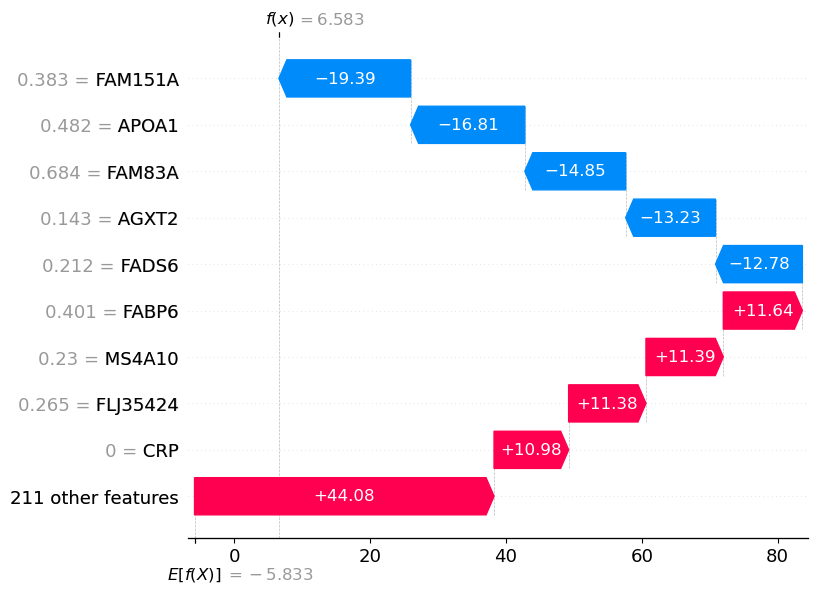

In [27]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [28]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [29]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [30]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

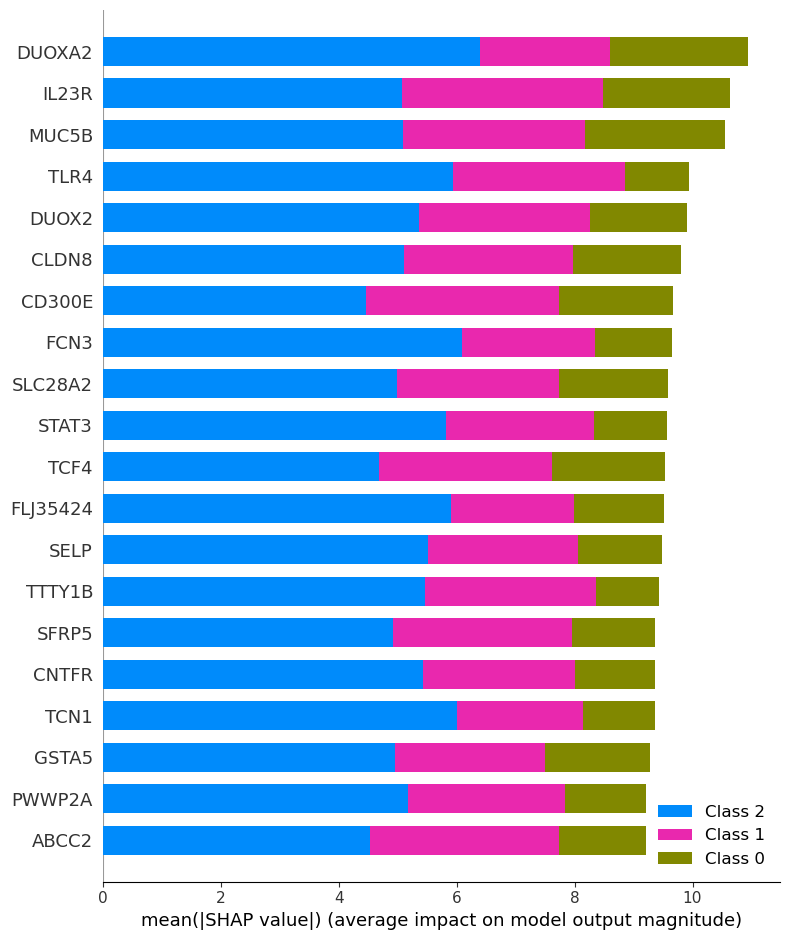

In [31]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


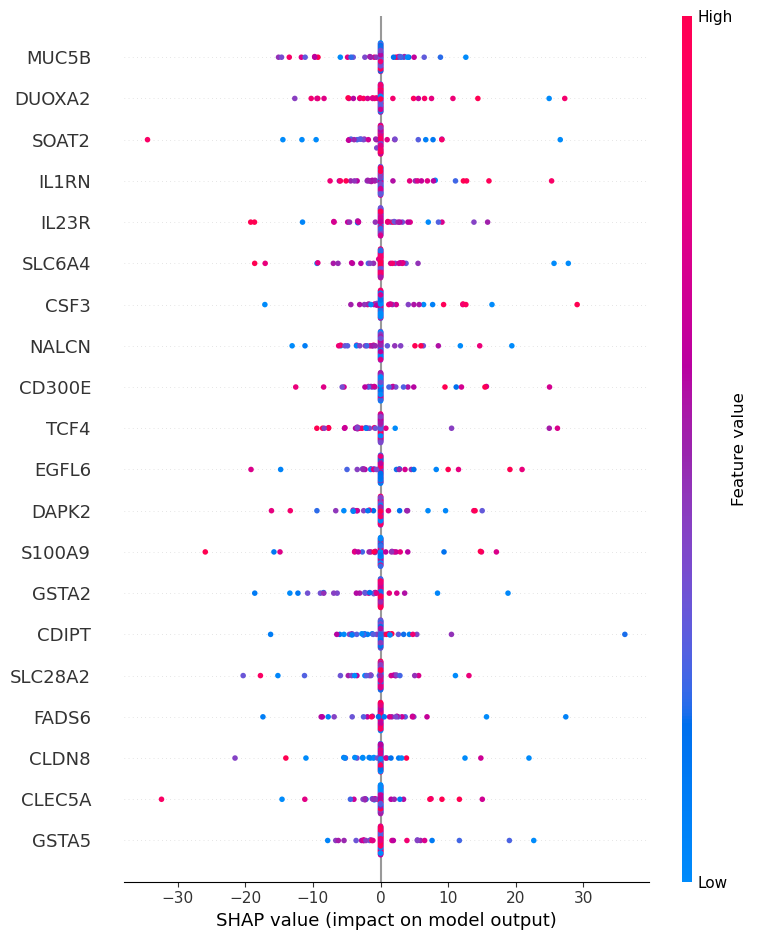

In [32]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

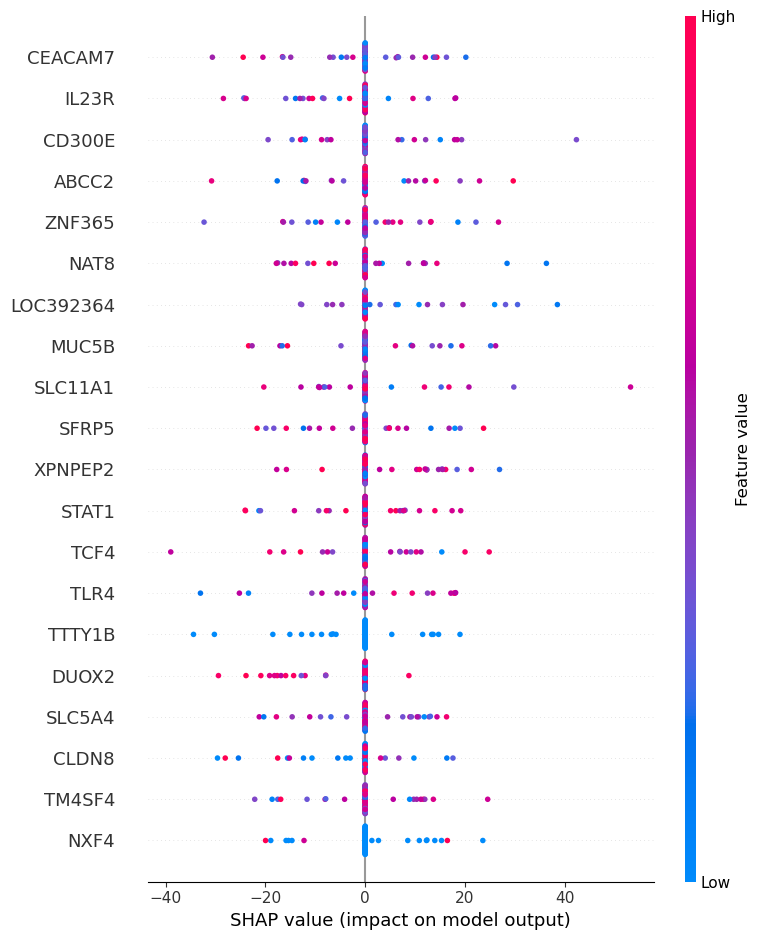

In [33]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

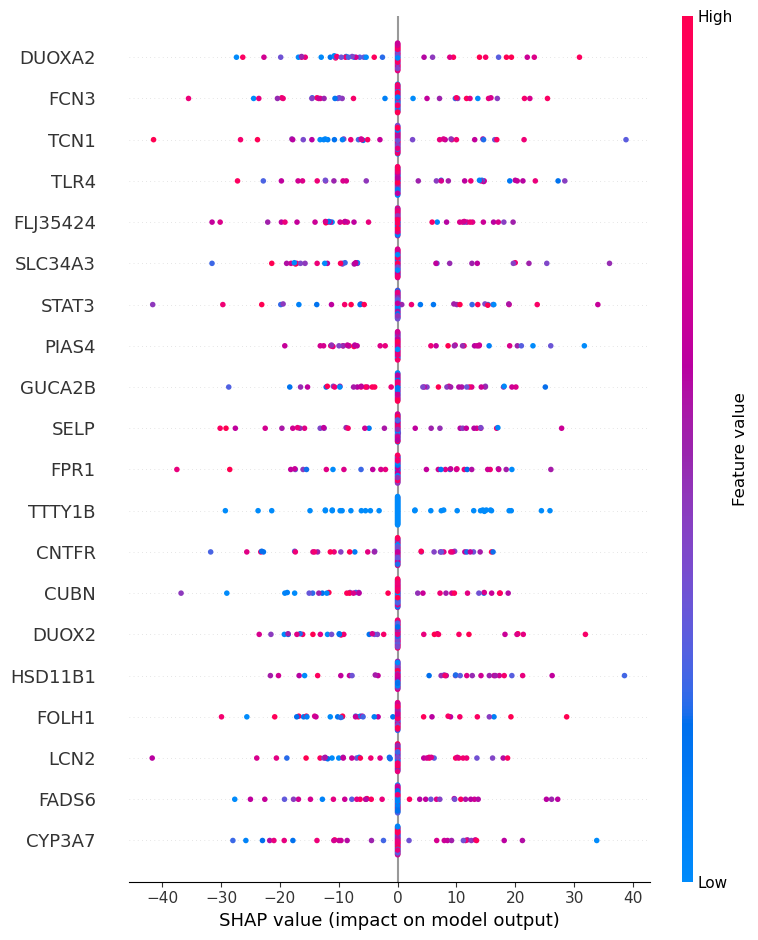

In [34]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

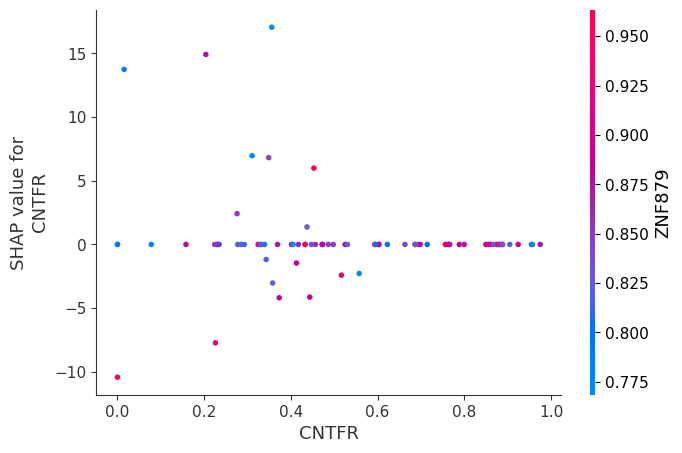

In [35]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

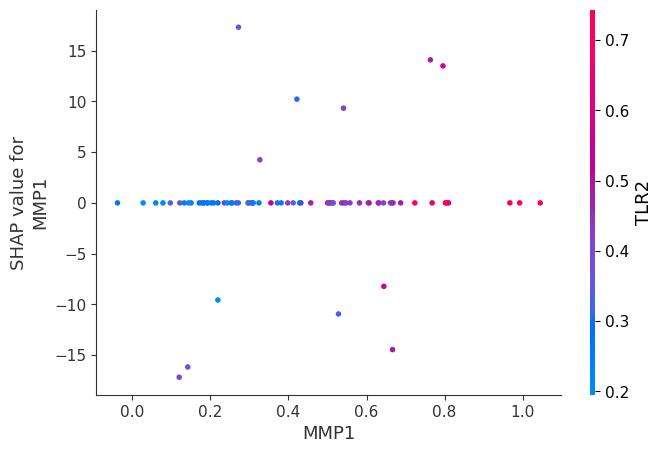

In [36]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

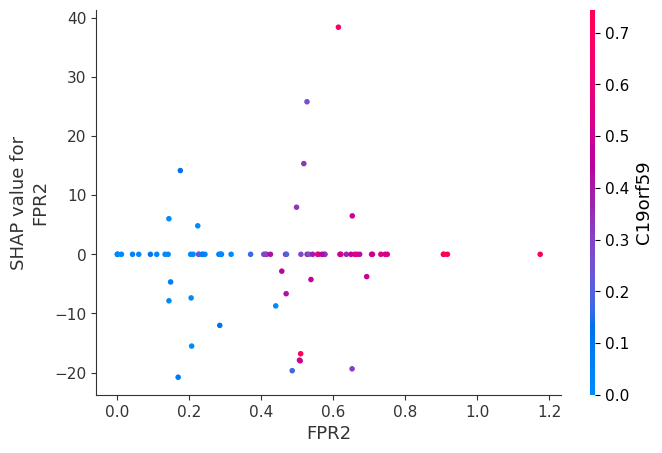

In [37]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [38]:
disease_labels_test.shape

(78,)

In [39]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [40]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 13 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 78%|████████████████████████████████████████████████████████▎               | 172/220 [01:07<00:19,  2.44it/s]No/low signal found from feature 171 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 172 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 98%|██████████████████████████████████████████████████████████████████████▋ | 216/220 [01:23<00:01,  3.35it/s]No/low signal found from feature 215 (this is typically caused by constant or

In [41]:
# clustering

In [42]:
# clustering.shape

In [43]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [44]:
type(exp)

shap._explanation.Explanation

In [45]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [46]:

# with open("../clust", "rb") as fp:   # Unpickling
#     clustering = pickle.load(fp)

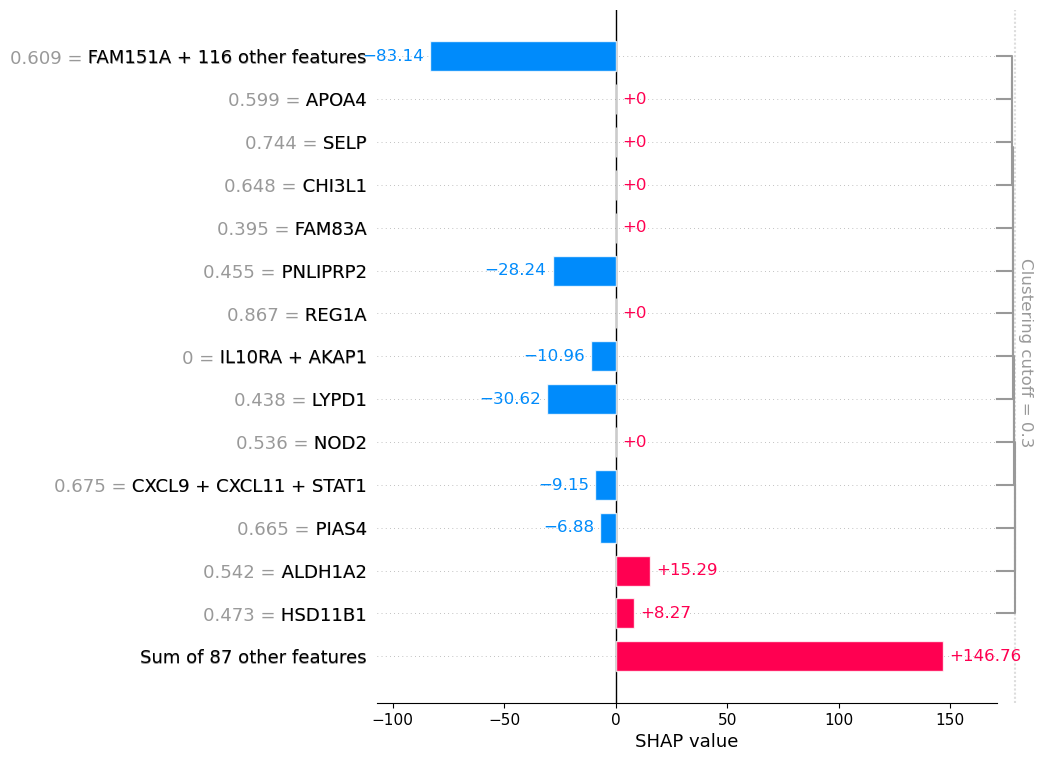

In [47]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [48]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [49]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
167_CD_deep_ulcer,0.000000,0.000000,-23.156386,13.107862,0.000000,-12.492736,0.000000,0.000000,-17.214661,-12.493827,...,25.314541,0.000000,22.245032,11.032543,0.000000,-26.854013,0.000000,0.000000,21.718127,13.224693
196_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-21.534164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23_CD_deep_ulcer,-10.214387,22.243430,0.000000,0.000000,7.754758,-11.234637,5.825867,-10.861167,0.000000,0.000000,...,0.000000,-9.964379,27.674655,25.143619,0.000000,15.164989,0.000000,-11.938854,0.000000,0.000000
93_CD_deep_ulcer,0.000000,0.000000,-11.823692,-12.521580,0.000000,0.000000,0.000000,0.000000,0.000000,22.655923,...,0.000000,11.284981,16.711766,0.000000,0.000000,0.000000,0.000000,0.000000,12.707631,-15.233424
229_CD_deep_ulcer,7.424135,8.593257,-16.054642,-6.026212,5.208854,0.000000,-14.418762,-8.876302,-9.476502,11.700926,...,-10.991097,-8.523369,0.000000,3.046728,18.006757,11.686611,4.705322,2.792105,17.612033,-13.282476
46_CD_deep_ulcer,0.000000,-16.812382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,9.615495,0.000000,-14.846037,0.000000,0.000000,0.000000,0.000000,0.000000
176_CD_deep_ulcer,-8.414677,22.724088,-5.381184,7.395459,-6.124100,20.488951,5.512617,0.000000,25.420711,10.072318,...,0.000000,-12.578601,6.629832,0.000000,0.000000,12.562455,10.298832,9.409479,-11.727843,-4.569783
49_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,-13.587867,0.000000,0.000000,0.000000,0.000000,11.510526,...,0.000000,-7.414915,13.174529,0.000000,0.000000,0.000000,0.000000,14.747743,0.000000,0.000000


### Example: CD deep ulcer patients

In [50]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

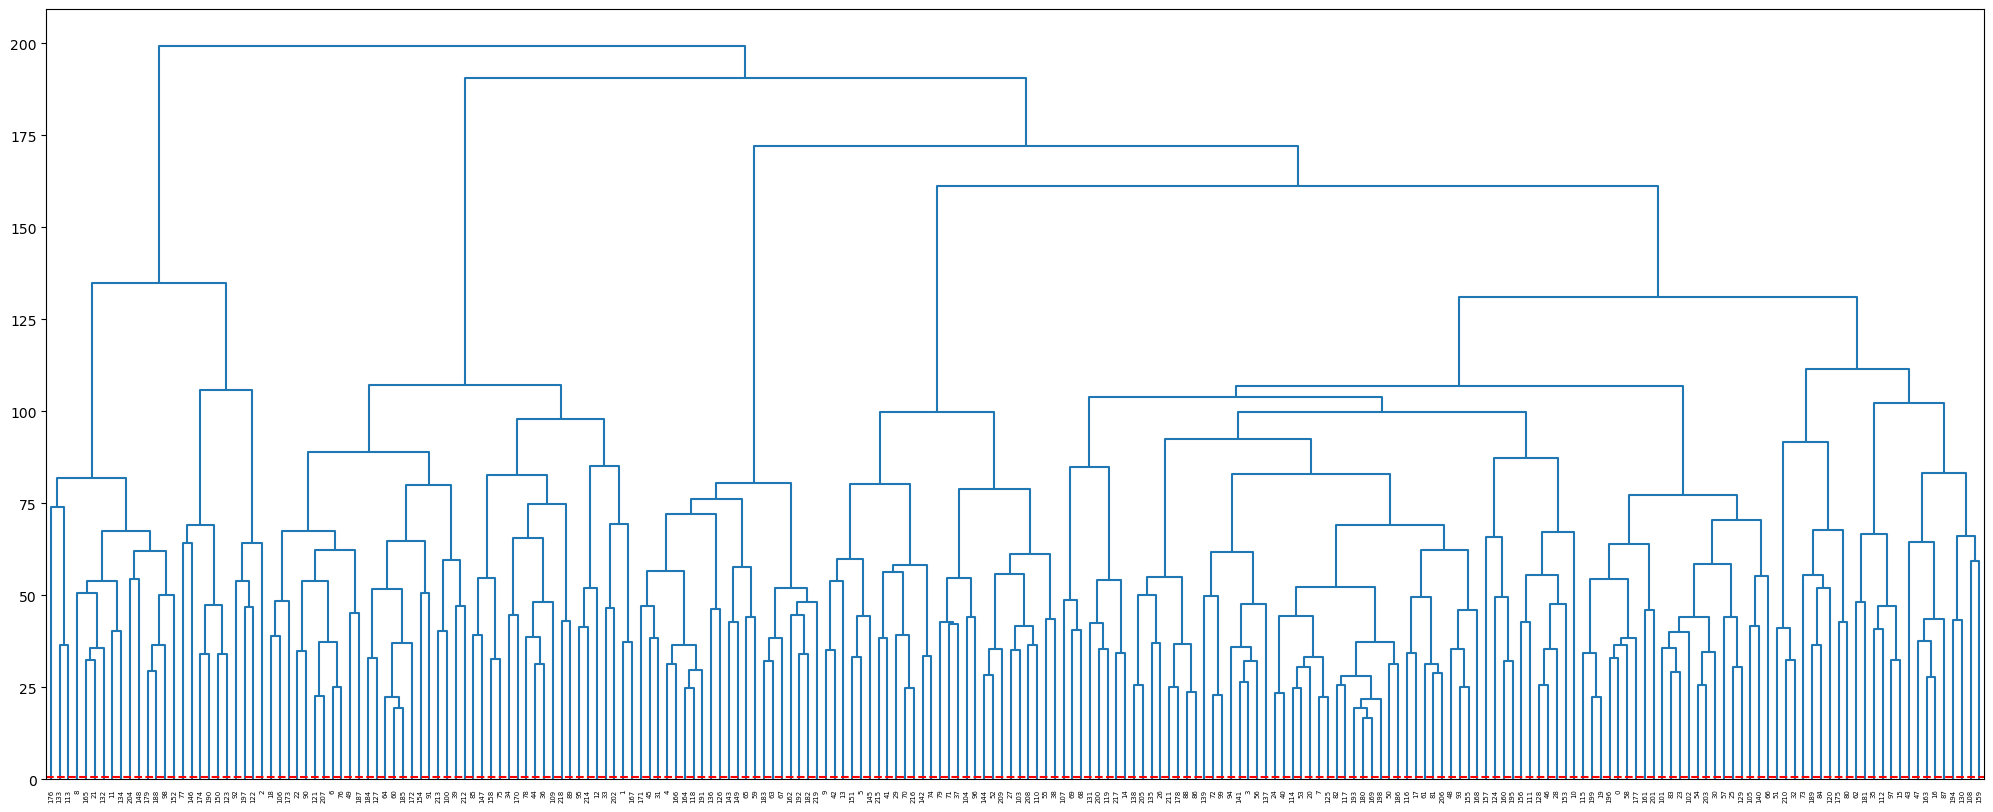

In [51]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = .7, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [52]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([176, 133, 113,   8, 165,  21, 132,  11, 134, 204, 148, 179, 188,
        98, 152,  77, 146, 174, 190, 150, 123,  92, 197, 122,   2,  18,
       106, 173,  22,  90, 121, 207,   6,  76,  49, 187, 184, 127,  64,
        60, 185, 172, 154,  91, 213, 100,  39, 212,  85, 147, 158,  75,
        34, 170,  78,  44,  36, 109, 218,  89,  95, 214,  12,  33, 202,
         1, 167, 171,  45,  31,   4, 166, 164, 118, 191, 136, 126, 143,
       149,  65,  59, 183,  63,  67, 162, 192, 182, 219,   9,  42,  13,
       151,   5, 145, 215,  41,  29,  70, 216, 142,  74,  79,  71,  37,
       104,  96, 144,  52, 209,  27, 103, 208, 110,  55,  38, 107,  69,
        68, 131, 200, 119, 217,  14, 138, 205, 135,  26, 211, 178,  88,
        86, 139,  72,  99,  94, 141,   3,  56, 137,  24,  40, 114,  53,
        20,   7, 125,  82, 117, 193, 180, 169, 198,  50, 186, 116,  17,
        61,  81, 206,  48,  93, 155, 168, 157, 124, 160, 195, 156, 111,
       128,  46,  28, 153,  10, 115, 199,  19, 196,   0,  58, 17

In [53]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

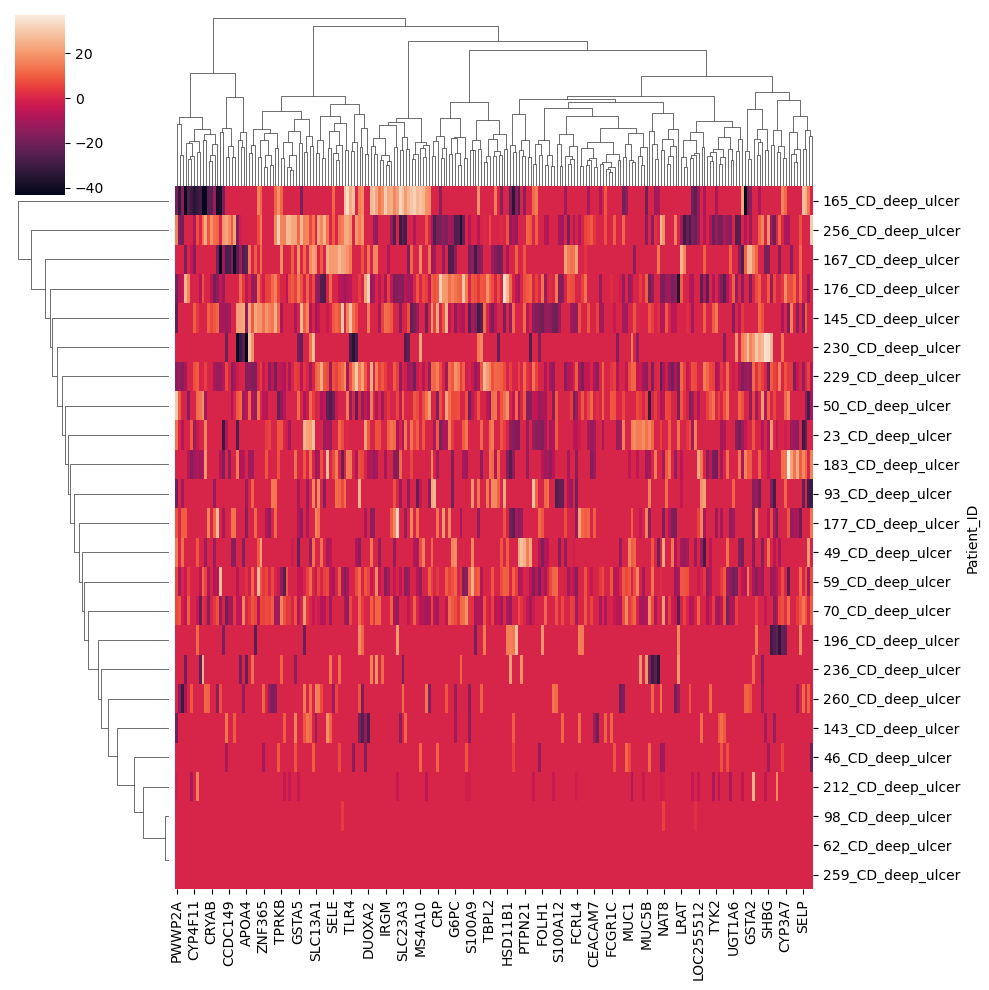

In [54]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [55]:
gene_cluster_cd_deep

array([[180.        , 169.        ,  16.65036488,   2.        ],
       [ 60.        , 185.        ,  19.37499571,   2.        ],
       [193.        , 220.        ,  19.45465226,   3.        ],
       [222.        , 198.        ,  21.80244461,   4.        ],
       [  7.        , 125.        ,  22.32336436,   2.        ],
       [199.        ,  19.        ,  22.37667719,   2.        ],
       [ 64.        , 221.        ,  22.39050572,   3.        ],
       [121.        , 207.        ,  22.70256135,   2.        ],
       [ 72.        ,  99.        ,  22.9783466 ,   2.        ],
       [ 24.        ,  40.        ,  23.32555294,   2.        ],
       [ 88.        ,  86.        ,  23.61493255,   2.        ],
       [114.        ,  53.        ,  24.64287821,   2.        ],
       [164.        , 118.        ,  24.83933177,   2.        ],
       [ 70.        , 216.        ,  24.88523751,   2.        ],
       [ 93.        , 155.        ,  25.02499183,   2.        ],
       [211.        , 178

In [56]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [57]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([133, 113, 176, 165,  21, 132,   8,  11, 134, 204, 148, 179, 188,
         98, 152,  77, 146, 174, 190, 150, 123, 197, 122,  92,   2,  18,
        106, 173,  22,  90, 121, 207,   6,  76,  49, 187, 184, 127,  60,
        185,  64, 172, 154,  91, 213, 100,  39, 212,  85, 147, 158,  75,
         34, 170,  44,  36,  78, 109, 218,  89,  95, 214,  12,  33, 202,
          1, 167,  45,  31, 171,   4, 166, 164, 118, 191, 136, 126, 143,
        149,  65,  59, 183,  63,  67, 192, 182, 162, 219,   9,  42,  13,
        151,   5, 145, 215,  41,  70, 216,  29, 142,  74,  71,  37,  79,
        104,  96, 144,  52, 209,  27, 103, 208, 110,  55,  38,  69,  68,
        107, 200, 119, 131, 217,  14, 138, 205, 135,  26, 211, 178,  88,
         86,  72,  99, 139, 141,   3,  56,  94, 137,  24,  40, 114,  53,
         20,   7, 125,  82, 117, 180, 169, 193, 198,  50, 186, 116,  17,
         81, 206,  61,  93, 155,  48, 168, 160, 195, 124, 157, 156, 111,
        128,  46,  28, 153,  10, 199,  19, 115, 196

In [58]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [59]:
cluster_labels

array([179,  66,  25, 136,  71,  93,  33, 145,   7,  89, 174,   8,  63,
        91, 123, 211, 213, 156,  26, 176, 144,   5,  29, 185, 140, 191,
       127, 110, 172,  99, 190,  69, 198,  64,  53, 208,  56, 103, 115,
        47, 141,  96,  90, 216,  55,  68, 171, 214, 162,  35, 153, 199,
       108, 143, 188, 114, 137, 193, 180,  81,  39, 159, 206,  83,  41,
        80, 196,  84, 117, 116,  97, 102, 132, 203, 101,  52,  34,  16,
        57, 104, 205, 157, 147, 184, 201,  49, 131, 215, 130,  60,  30,
        44,  24, 160, 138,  61, 106, 210,  14, 133,  46, 186, 187, 111,
       105, 194,  27, 118, 219,  58, 113, 169, 209,   2, 142, 177, 155,
       148,  74, 120, 202,  31,  23,  21, 166, 146,  77,  38, 170, 192,
       218, 121,   6,   1,   9, 126,  76, 139, 124, 134, 195, 135, 100,
        78, 107,  94,  17,  50,  11,  79,  20,  92,  15, 173,  43, 161,
       168, 167,  51, 220, 164, 182,  87, 212,  73,   4,  72,  67, 163,
       150,  54,  70,  42,  28,  18, 204,   3, 181, 129,  12, 14

In [60]:
df_cd_deep.columns.get_loc("OSM")

63

In [61]:
np.where(cluster_labels == 2) #osm

(array([113], dtype=int64),)

In [62]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,-3.395260,6.483766,-20.013260,-7.301051,0.0,0.000000,7.424135,AADAC,179
APOA1,24.0,0.725451,8.667960,-16.812382,0.000000,0.0,0.000000,22.724088,APOA1,66
APOA4,24.0,-6.454838,11.044455,-43.159946,-12.548411,0.0,0.000000,2.497667,APOA4,25
APOB,24.0,-0.129444,5.172179,-12.521580,0.000000,0.0,0.000000,13.107862,APOB,136
APOC3,24.0,0.174391,5.724232,-13.587867,0.000000,0.0,0.000000,14.244240,APOC3,71
...,...,...,...,...,...,...,...,...,...,...
NXF4,24.0,1.889569,9.116016,-26.854013,0.000000,0.0,7.057386,16.768163,NXF4,95
RNF125,24.0,-0.514285,8.916022,-35.875194,0.000000,0.0,0.000000,11.725952,RNF125,98
DARS,24.0,-0.517986,6.699127,-15.725258,0.000000,0.0,0.000000,14.747743,DARS,122
DNAI1,24.0,2.669912,10.701431,-16.428665,0.000000,0.0,0.000000,28.005197,DNAI1,59


In [63]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-3.395260,179,AADAC
APOA1,0.725451,66,APOA1
APOA4,-6.454838,25,APOA4
APOB,-0.129444,136,APOB
APOC3,0.174391,71,APOC3
...,...,...,...
NXF4,1.889569,95,NXF4
RNF125,-0.514285,98,RNF125
DARS,-0.517986,122,DARS
DNAI1,2.669912,59,DNAI1


In [64]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-3.395260,179,AADAC
APOA1,0.725451,66,APOA1
APOA4,-6.454838,25,APOA4
APOB,-0.129444,136,APOB
APOC3,0.174391,71,APOC3
...,...,...,...
NXF4,1.889569,95,NXF4
RNF125,-0.514285,98,RNF125
DARS,-0.517986,122,DARS
DNAI1,2.669912,59,DNAI1


In [65]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [66]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [67]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: abs(mean_vals[i]) for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [68]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-3.166544,1,[PROK2]
2,-3.610357,1,[SLC28A2]
3,-0.816971,1,[PWWP2A]
4,-0.760514,1,[OTOP3]
5,-1.814944,1,[FCGR3B]
...,...,...,...
216,1.468386,1,[CXCR2]
217,-0.430802,1,[SELP]
218,1.031710,1,[ATG16L1]


In [69]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-3.166544,1,[PROK2],PROK2
2,-3.610357,1,[SLC28A2],SLC28A2
3,-0.816971,1,[PWWP2A],PWWP2A
4,-0.760514,1,[OTOP3],OTOP3
5,-1.814944,1,[FCGR3B],FCGR3B
...,...,...,...,...
216,1.468386,1,[CXCR2],CXCR2
217,-0.430802,1,[SELP],SELP
218,1.031710,1,[ATG16L1],ATG16L1


In [70]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [71]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
3,-3.166544,1,[PROK2],PROK2
1,-3.610357,1,[SLC28A2],SLC28A2
2,-0.816971,1,[PWWP2A],PWWP2A
7,-0.760514,1,[OTOP3],OTOP3
4,-1.814944,1,[FCGR3B],FCGR3B
...,...,...,...,...
215,1.468386,1,[CXCR2],CXCR2
217,-0.430802,1,[SELP],SELP
218,1.031710,1,[ATG16L1],ATG16L1
219,-1.192152,1,[HCAR3],HCAR3


In [72]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-3.610357,1,[SLC28A2],SLC28A2
2,-0.816971,1,[PWWP2A],PWWP2A
3,-3.166544,1,[PROK2],PROK2
4,-1.814944,1,[FCGR3B],FCGR3B
5,-2.711611,1,[CYP4F11],CYP4F11
...,...,...,...,...
216,-0.556551,1,[CD300E],CD300E
217,-0.430802,1,[SELP],SELP
218,1.031710,1,[ATG16L1],ATG16L1
219,-1.192152,1,[HCAR3],HCAR3


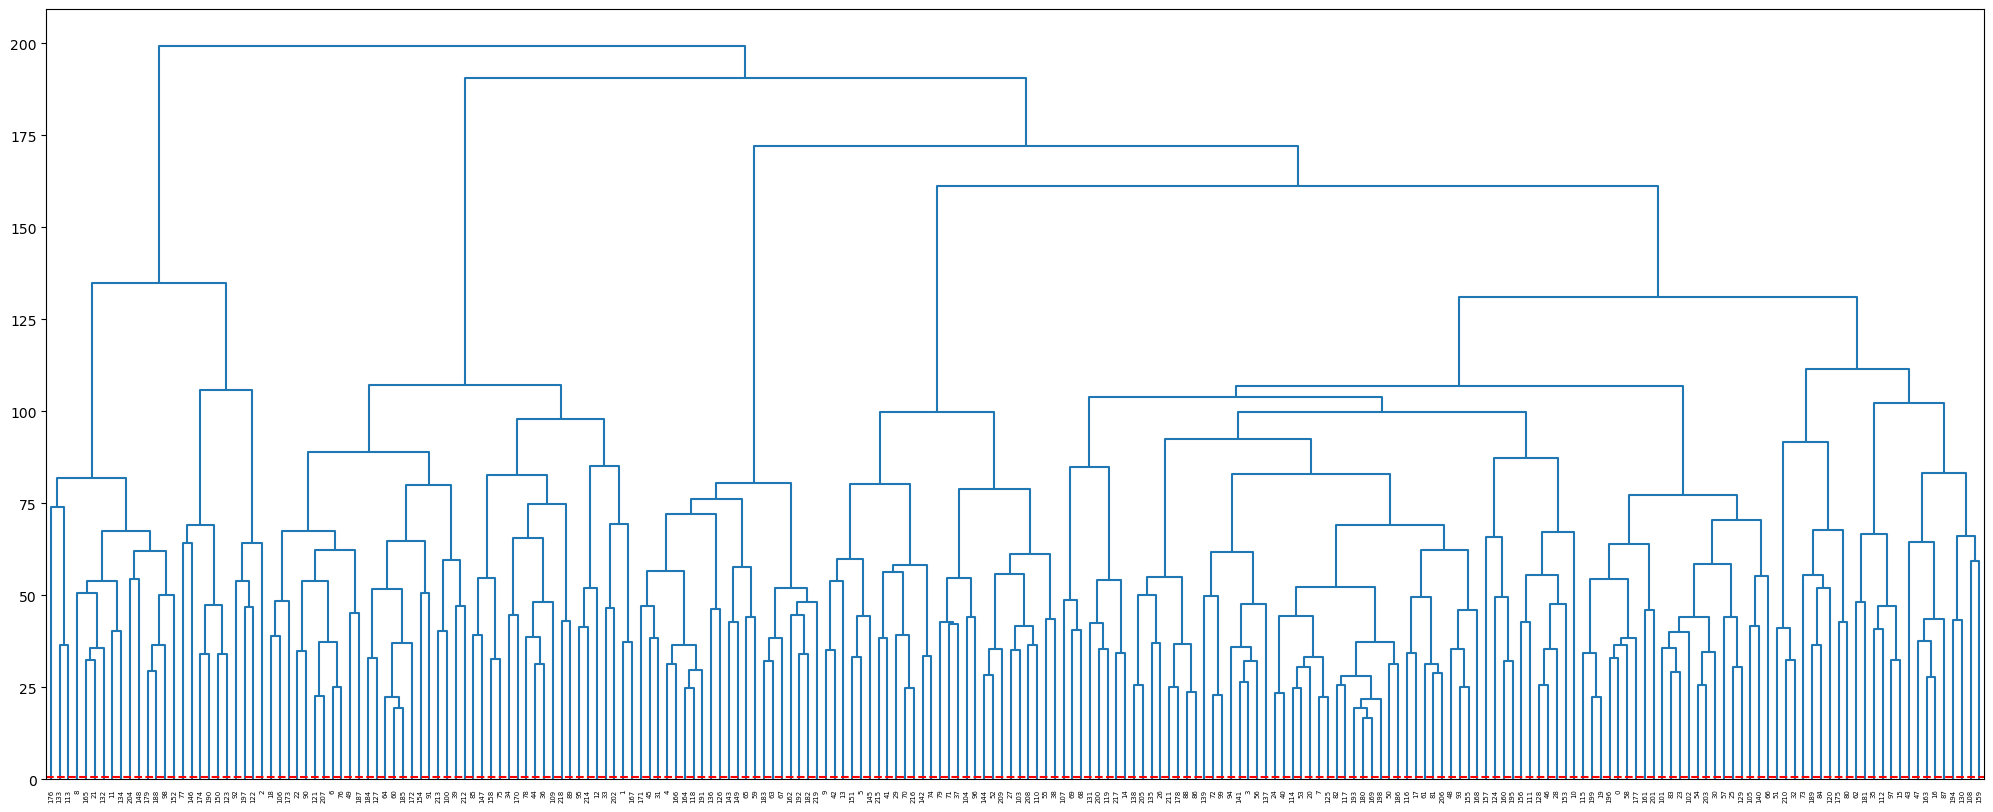

In [73]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

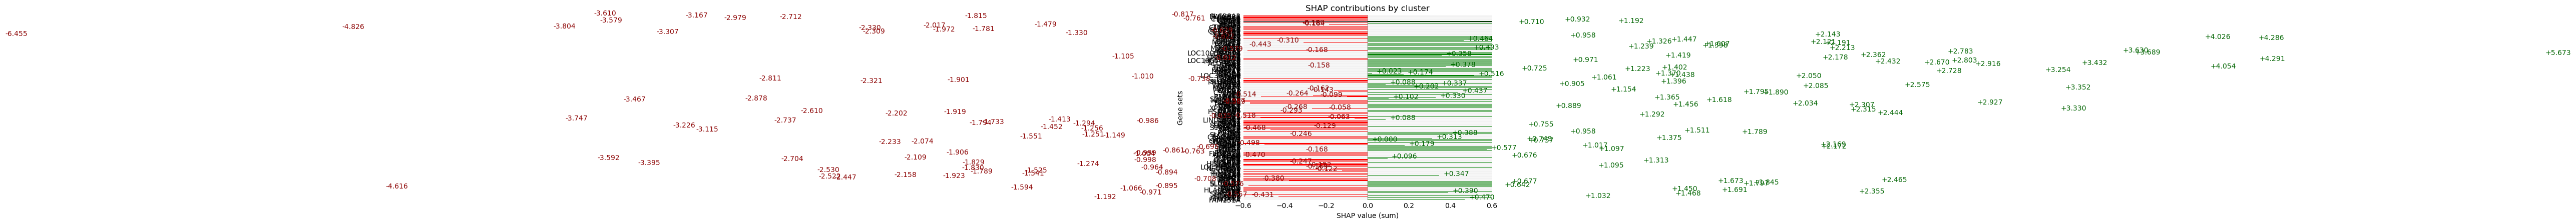

In [74]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [75]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [76]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

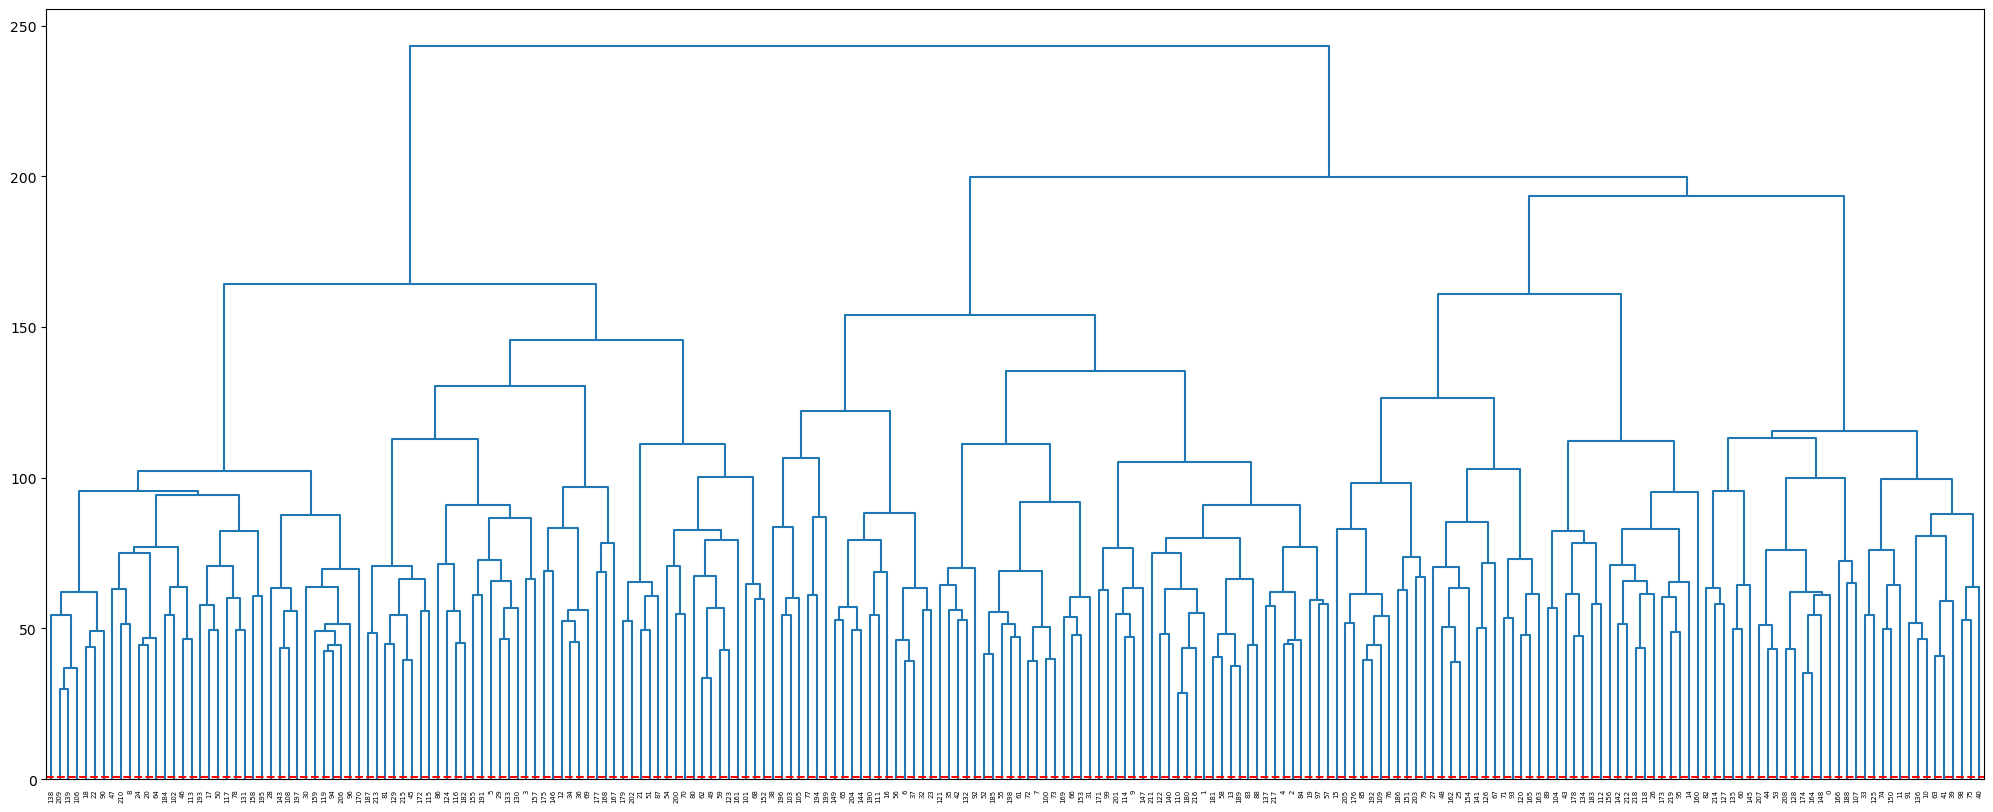

In [77]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = .8)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [78]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([138, 209, 139, 106,  18,  22,  90,  47, 210,   8,  24,  20,  64,
       184, 102,  46, 113, 193,  17,  50, 117,  78, 131, 158, 195,  28,
       143, 108, 197,  30, 159, 119,  94, 206,  96, 170, 187, 213,  81,
       129, 215,  45, 172, 115,  86, 124, 116, 182, 155, 191,   5,  29,
       133, 130,   3, 157, 175, 146,  12,  34,  36,  69, 177, 168, 167,
       179, 202,  21,  51,  87,  54, 200,  70,  80,  62,  49,  59, 123,
       161, 101,  68, 152,  38, 196, 103, 105,  77, 194, 199, 149,  65,
       204, 144, 190, 111,  16,  56,   6,  37,  32,  23, 121,  35,  42,
       132,  92,  52, 185,  55, 198,  61,  72,   7, 100,  73, 169,  66,
       153,  31, 171,  99, 201, 114,   9, 147, 211, 122, 140, 110, 180,
       216,   1, 181,  58,  13, 189,  83,  88, 137, 217,   4,   2,  84,
        19,  97,  57,  15, 205, 176,  85, 192, 109,  76, 186, 151, 203,
        79,  27,  48, 162,  25, 154, 141, 126,  67,  71,  93, 120, 165,
       163,  89, 104,  43, 178, 134, 183, 112, 156, 142, 212, 21

In [79]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

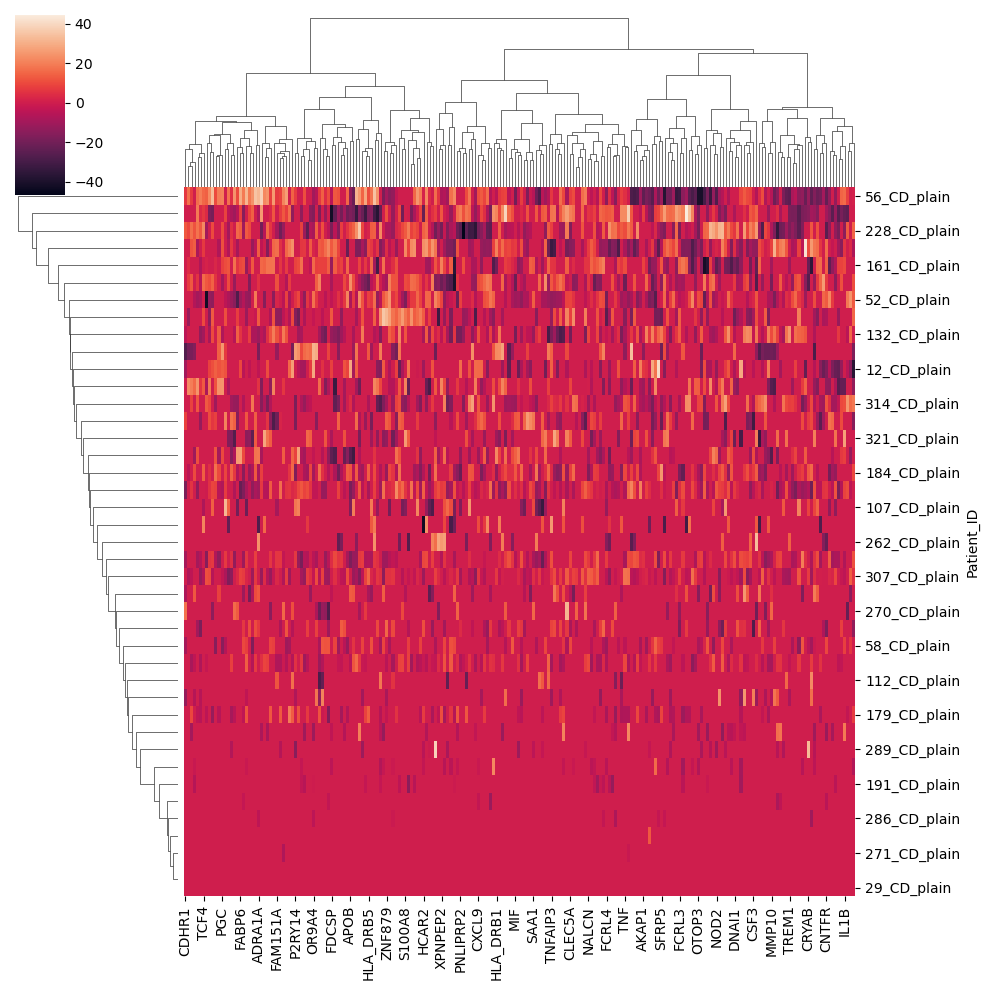

In [80]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing potential gene modules alongside SHAP contributions

In [81]:
gene_cluster_cd_plain

array([[110.        , 180.        ,  28.67023543,   2.        ],
       [209.        , 139.        ,  29.87013787,   2.        ],
       [ 62.        ,  49.        ,  33.47412384,   2.        ],
       [174.        , 164.        ,  35.37060084,   2.        ],
       [221.        , 106.        ,  37.03837849,   3.        ],
       [ 13.        , 189.        ,  37.55406231,   2.        ],
       [162.        ,  25.        ,  38.9344264 ,   2.        ],
       [  6.        ,  37.        ,  39.2207919 ,   2.        ],
       [ 72.        ,   7.        ,  39.32550617,   2.        ],
       [ 85.        , 192.        ,  39.4880207 ,   2.        ],
       [215.        ,  45.        ,  39.54148349,   2.        ],
       [100.        ,  73.        ,  39.84194928,   2.        ],
       [181.        ,  58.        ,  40.44141741,   2.        ],
       [ 63.        ,  41.        ,  40.73639442,   2.        ],
       [ 52.        , 185.        ,  41.43518981,   2.        ],
       [119.        ,  94

In [82]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [83]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([209, 139, 106, 138,  18,  22,  90, 210,   8,  47,  24,  20,  64,
        184, 102,  46, 113,  17,  50, 193,  78, 131, 117, 158, 195, 143,
        108, 197,  28, 119,  94, 206, 159,  96,  30, 170, 187, 213,  81,
        129, 215,  45, 172, 115, 116, 182, 124,  86, 155, 191,  29, 133,
        130,   5,   3, 157, 175, 146,  34,  36,  12,  69, 177, 168, 167,
        179, 202,  21,  51,  87, 200,  70,  54,  62,  49,  59, 123,  80,
        161,  68, 152, 101, 196, 103, 105,  38,  77, 194, 199, 149,  65,
        204, 144, 190, 111,  16,   6,  37,  56,  32,  23,  42, 132,  35,
        121,  92,  52, 185, 198,  61,  55,  72,   7, 100,  73,  66, 153,
        169,  31, 171,  99, 114,   9, 201, 147, 122, 140, 110, 180, 216,
          1, 211, 181,  58,  13, 189,  83,  88, 137, 217,   4,   2,  84,
         97,  57,  19, 205, 176,  85, 192, 109,  76,  15, 186, 151, 203,
         79, 162,  25,  48, 154,  27, 141, 126,  67,  71,  93, 120, 165,
        163,  89, 104, 178, 134,  43, 183, 112, 142

In [84]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [85]:
cluster_labels

array([203, 131, 142,  55, 141,  54,  97, 113,   9, 123, 213, 211,  61,
       135, 187, 153,  96,  18,   5, 146,  12,  68,   6, 101,  11, 159,
       182, 162,  29,  51,  35, 119, 100, 207,  59, 104,  60,  98,  86,
       217, 220, 216, 102, 175, 195,  42,  16,  10, 160,  75,  19,  69,
       107, 196,  73, 111,  99, 145, 134,  76, 193, 110,  74, 215,  13,
        91, 116, 165,  80,  62,  72, 166, 112, 115, 209, 219, 152,  87,
        21, 157,  78,  39, 191, 137, 143, 149,  48,  70, 138, 171,   7,
       214, 106, 167,  31, 185,  34, 144, 218, 121, 114,  82,  15,  84,
       172,  85,   3, 205,  27, 151, 128,  95, 177,  17, 122,  44,  45,
        23, 181,  30, 168, 105, 126,  77,  47, 208, 164, 190, 199,  40,
        53,  22, 103,  52, 174, 192, 212, 139,   4,   2, 127, 163, 178,
        26,  93, 194,  58, 125, 202,  90, 210, 155,  81, 117, 161,  49,
       183,  56,  24,  33, 188,  79, 158, 170, 201, 169, 206,  65,  64,
       118,  36, 120,  43, 186, 200,  57, 148,  63, 173,  66, 12

In [86]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,-0.782082,7.987069,-19.373929,0.0,0.0,0.0,19.684965,AADAC,203
APOA1,41.0,1.015558,8.139270,-25.006702,0.0,0.0,0.0,20.043312,APOA1,131
APOA4,41.0,-1.651907,6.647848,-17.044700,0.0,0.0,0.0,17.680519,APOA4,142
APOB,41.0,-0.734864,9.994154,-26.180565,0.0,0.0,0.0,28.405660,APOB,55
APOC3,41.0,0.029461,6.236020,-15.745945,0.0,0.0,0.0,17.068444,APOC3,141
...,...,...,...,...,...,...,...,...,...,...
NXF4,41.0,0.658217,6.450120,-24.064023,0.0,0.0,0.0,17.639690,NXF4,41
RNF125,41.0,1.578860,5.749351,-14.911781,0.0,0.0,0.0,16.387953,RNF125,130
DARS,41.0,-2.054495,8.349975,-22.474287,0.0,0.0,0.0,23.983841,DARS,140
DNAI1,41.0,-1.152609,7.056181,-21.416769,0.0,0.0,0.0,15.584397,DNAI1,180


In [87]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-0.782082,203,AADAC
APOA1,1.015558,131,APOA1
APOA4,-1.651907,142,APOA4
APOB,-0.734864,55,APOB
APOC3,0.029461,141,APOC3
...,...,...,...
NXF4,0.658217,41,NXF4
RNF125,1.578860,130,RNF125
DARS,-2.054495,140,DARS
DNAI1,-1.152609,180,DNAI1


In [88]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-0.782082,203,AADAC
APOA1,1.015558,131,APOA1
APOA4,-1.651907,142,APOA4
APOB,-0.734864,55,APOB
APOC3,0.029461,141,APOC3
...,...,...,...
NXF4,0.658217,41,NXF4
RNF125,1.578860,130,RNF125
DARS,-2.054495,140,DARS
DNAI1,-1.152609,180,DNAI1


In [89]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,0.392176,1,[TBPL2]
2,1.231148,1,[OTOP2]
3,0.309947,1,[CYP4F2]
4,-1.274921,1,[CDHR1]
5,1.246028,1,[FCGR1A]
...,...,...,...
216,-0.293513,1,[IL8]
217,1.028249,1,[IL1B]
218,0.350427,1,[TNFAIP2]


In [90]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,0.392176,1,[TBPL2],TBPL2
2,1.231148,1,[OTOP2],OTOP2
3,0.309947,1,[CYP4F2],CYP4F2
4,-1.274921,1,[CDHR1],CDHR1
5,1.246028,1,[FCGR1A],FCGR1A
...,...,...,...,...
216,-0.293513,1,[IL8],IL8
217,1.028249,1,[IL1B],IL1B
218,0.350427,1,[TNFAIP2],TNFAIP2


In [91]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [92]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
4,0.392176,1,[TBPL2],TBPL2
1,1.231148,1,[OTOP2],OTOP2
2,0.309947,1,[CYP4F2],CYP4F2
3,-1.274921,1,[CDHR1],CDHR1
5,1.246028,1,[FCGR1A],FCGR1A
...,...,...,...,...
216,-0.293513,1,[IL8],IL8
217,1.028249,1,[IL1B],IL1B
218,0.350427,1,[TNFAIP2],TNFAIP2
219,0.824345,1,[CXCL6],CXCL6


In [93]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,1.231148,1,[OTOP2],OTOP2
2,0.309947,1,[CYP4F2],CYP4F2
3,-1.274921,1,[CDHR1],CDHR1
4,0.392176,1,[TBPL2],TBPL2
5,1.246028,1,[FCGR1A],FCGR1A
...,...,...,...,...
216,-0.293513,1,[IL8],IL8
217,1.028249,1,[IL1B],IL1B
218,0.350427,1,[TNFAIP2],TNFAIP2
219,0.824345,1,[CXCL6],CXCL6


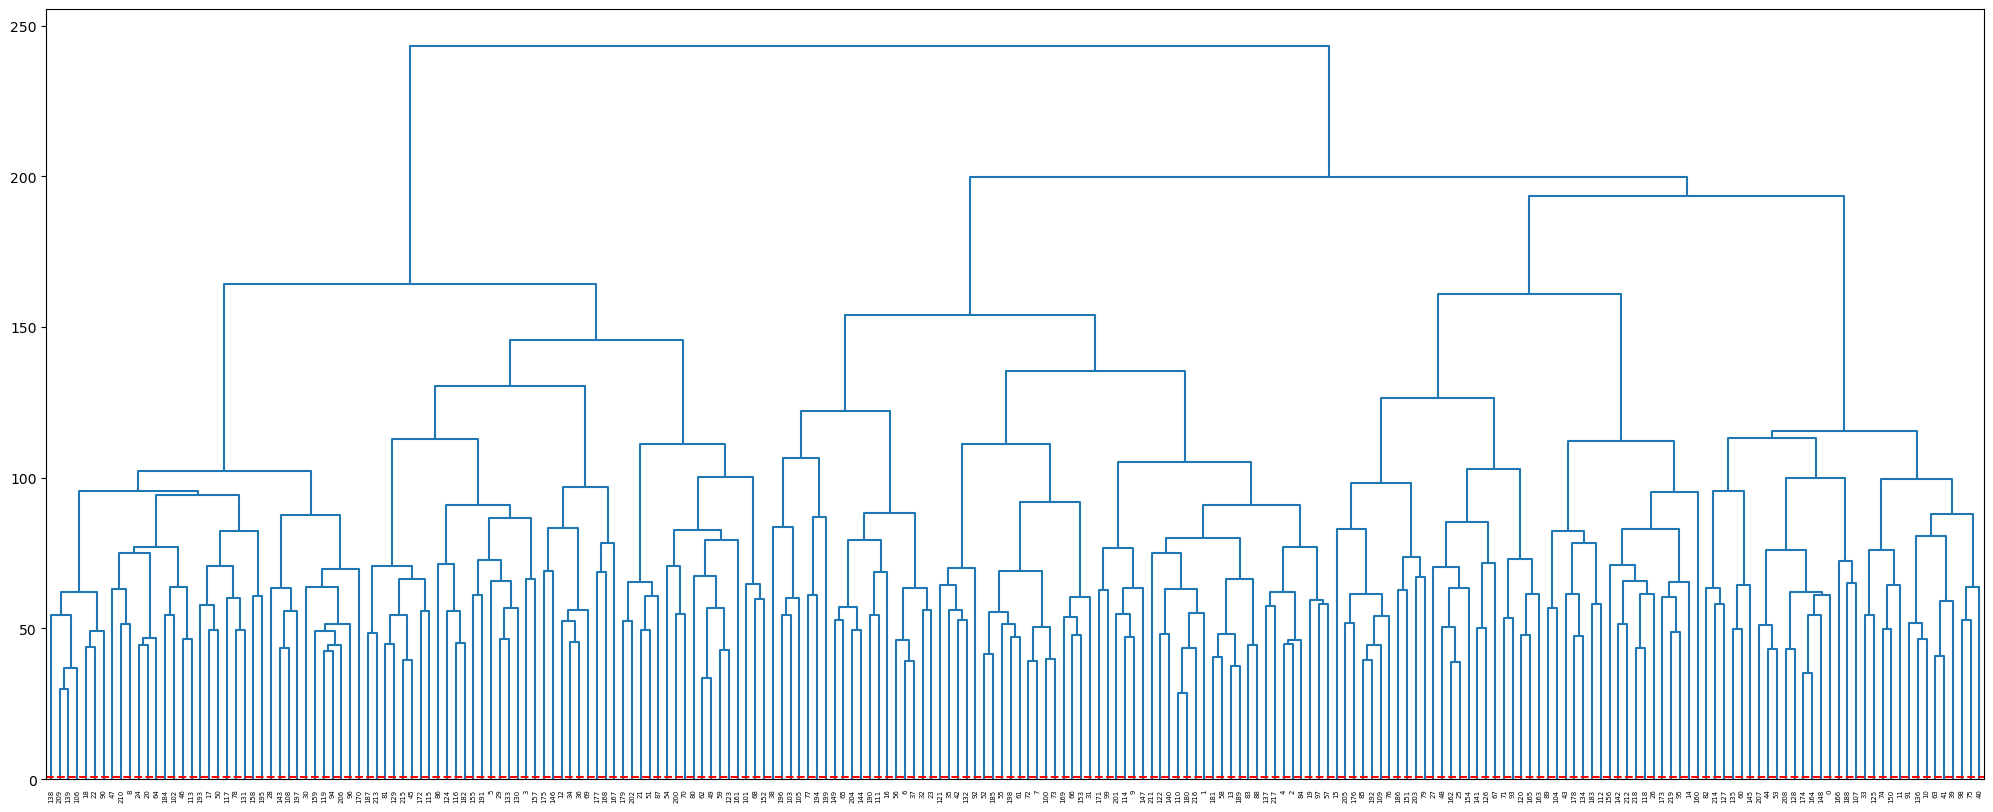

In [94]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

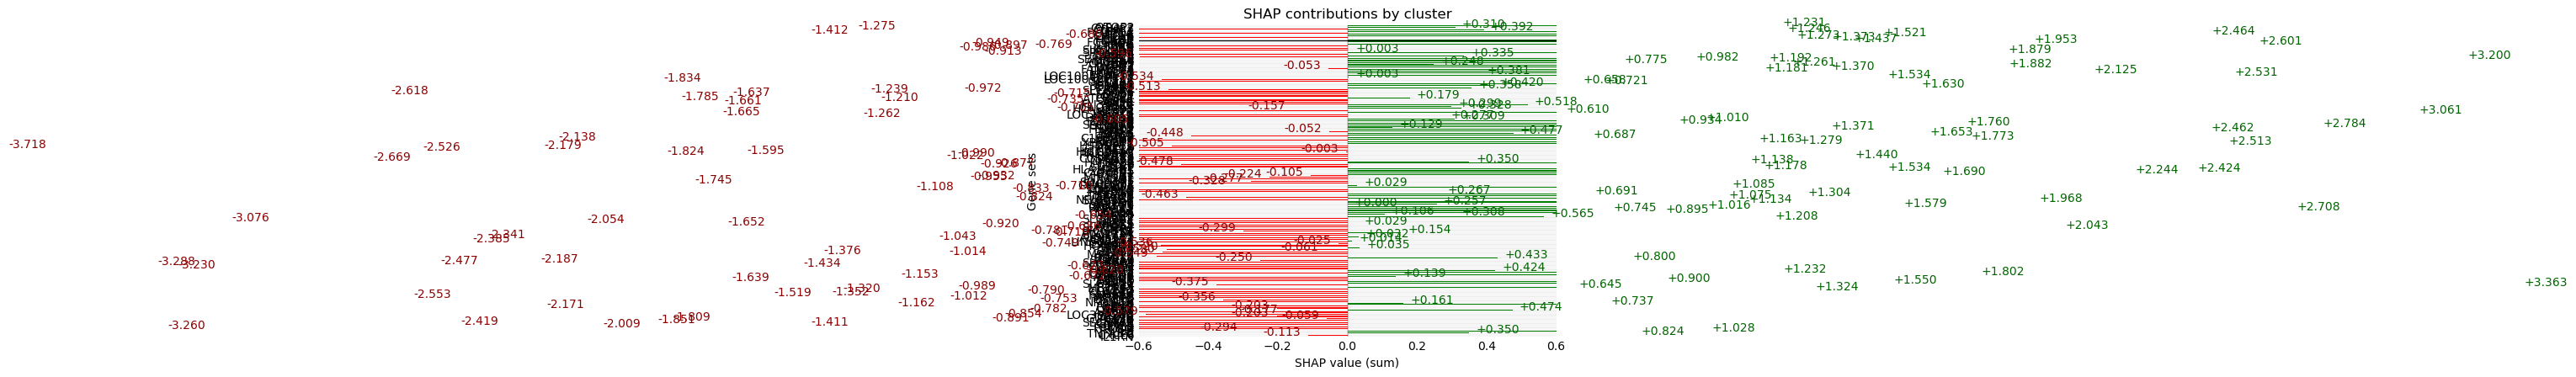

In [95]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [96]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")